<a href="https://colab.research.google.com/github/rajsegar/Federated-Learning-Frameworks-/blob/main/Spam_Mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Email Analysis using LLMs

## Introduction

This Jupyter notebook demonstrates how to use Large Language Models (LLMs) to analyze emails for potential phishing attempts. We'll use the Ollama framework to run a local LLM, then create a simple GUI for one-shot email analysis. Finally, we will test our process with a realworld datasets of phishing emails.

## Setup

Before we begin let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/phishing-email-dataset


# Step 1: Import Required Libraries
let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 2: Load the Dataset
 use a dataset containing labeled emails (Spam or Ham). Let’s load the dataset and inspect its structure.

In [ ]:
data = pd.read_csv('/phishing_email.csv')
data.head()


,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [ ]:
data.shape

(82486, 2)

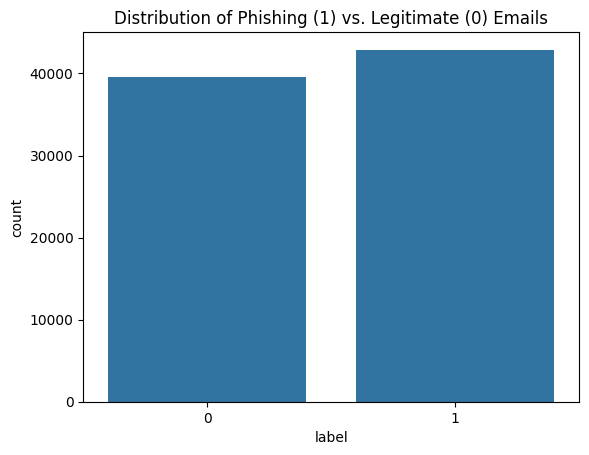

In [ ]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()